<a href="https://colab.research.google.com/github/lutfiis/knn/blob/main/Prototype%20Generation%20in%20KNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import time

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import MinMaxScaler,OneHotEncoder,LabelEncoder,OrdinalEncoder
from sklearn import metrics
from scipy import stats
from collections import defaultdict


# Preprocessing

In [ ]:
dataset = {
    1:'adult',
    2:'letter',
    3:'magic',
    4:'penbased',
    5:'shuttle',
    6:'skin',
    7:'chess',
}

uses_dataset = dataset[6]

df = pd.read_csv('drive/MyDrive/Dataset/'+uses_dataset+'.csv')
print(df.columns)
print(df.shape)
print(df.Class_label.value_counts())
df.head()

Index(['A1', 'A2', 'A3', 'Class_label'], dtype='object')
(245057, 4)
2    194198
1     50859
Name: Class_label, dtype: int64


,A1,A2,A3,Class_label
0,74,85,123,1
1,73,84,122,1
2,72,83,121,1
3,70,81,119,1
4,70,81,119,1


In [ ]:
X = df.drop(columns="Class_label").copy()
y = df.Class_label

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
# X_train.shape, X_test.shape, y_train.shape, y_test.shape

num_columns = ['FLength', 'FWidth', 'FSize', 'FConc', 'FConc1', 'FAsym', 'FM3Long',
       'FM3Trans', 'FAlpha', 'FDist']
cat_columns = []
pass_columns = []

X.shape

(245057, 3)

In [ ]:
#  numerical
num_pipe = Pipeline([
    # ("imputer",SimpleImputer(strategy="mean")),
    ("scaler",MinMaxScaler(feature_range=(1,2)))
])
#  categorical
cat_pipe = Pipeline([
    # ("imputer",SimpleImputer(strategy="most_frequent")),
    ("encoder",OrdinalEncoder())
])
# column transformer
preprocessor = ColumnTransformer([
    ("numeric", num_pipe, num_columns),
    ("categoric", cat_pipe, cat_columns)],
    remainder='passthrough'
)

In [ ]:
len_50 = len(df.index) // 2
len_75 = len(df.index) // 4
condensed_50 = MiniBatchKMeans(n_clusters=len_50,random_state=42,batch_size=len_50,max_iter=10)
condensed_75 = MiniBatchKMeans(n_clusters=len_75,random_state=42,batch_size=len_75,max_iter=10)

preprocessor.fit(X)
X_pre = preprocessor.transform(X)
X_pre = pd.DataFrame(X_pre,columns=num_columns+cat_columns+pass_columns)
if cat_columns :
    X_pre[cat_columns] +=1
df_pre = X_pre.copy()
df_pre['Class_label'] = y
print(df_pre.head(10))
clustered_X_pre_50 = X_pre.copy()
clustered_X_pre_75 = X_pre.copy()
cts_50 = time.time()
clustered_50 = condensed_50.fit(X_pre)
cte_50 = time.time()
cts_75 = time.time()
clustered_75 = condensed_75.fit(X_pre)
cte_75 = time.time()
clustered_X_pre_50['partisi'] = clustered_50.labels_
clustered_X_pre_75['partisi'] = clustered_75.labels_

X_pre.head()
print("con 50 time= "+str(cte_50 - cts_50)+" detik")
print("con 75 time= "+str(cte_75 - cts_75)+" detik")

    FLength    FWidth     FSize  ...    FAlpha     FDist  Class_label
0  1.074306  1.062415  1.208043  ...  1.445467  1.163066            g
1  1.082815  1.045727  1.170668  ...  1.070677  1.412679            g
2  1.478241  1.530579  1.626818  ...  1.855111  1.516926            g
3  1.059212  1.037338  1.117445  ...  1.116100  1.233582            g
4  1.214774  1.120603  1.360674  ...  1.051644  1.718582            g
5  1.143502  1.082495  1.285985  ...  1.040144  1.479113            g
6  1.133265  1.067698  1.322856  ...  1.053244  1.440651            g
7  1.068223  1.053668  1.180603  ...  1.009022  1.477163            g
8  1.278724  1.181434  1.654258  ...  1.053933  1.499604            g
9  1.128764  1.059284  1.188439  ...  1.087500  1.204274            g

[10 rows x 11 columns]
con 50 time= 82.64281296730042 detik
con 75 time= 33.999916553497314 detik


In [ ]:
#save preprocessed data to csv
df_pre.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_preprocessed.csv')
#save preprocessed data to excel
df_pre.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_preprocessed.xlsx')

In [ ]:
for train_index, test_index in fold:
    X_train, y_train =X.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X.iloc[test_index], y.iloc[test_index]

# Algo

In [ ]:
skf = StratifiedKFold(n_splits=10,shuffle=True,random_state=42)
fold = skf.split(X, y)
y_true = []
y_pred = defaultdict(list)
condensed_y_pred_50 = defaultdict(list)
condensed_y_pred_75 = defaultdict(list)
index = 0

for train_index, test_index in fold:
    index += 1
    X_train, clustered_X_train_50, clustered_X_train_75, y_train =X_pre.iloc[train_index], clustered_X_pre_50.iloc[train_index], clustered_X_pre_75.iloc[train_index], y.iloc[train_index]
    X_test, y_test = X_pre.iloc[test_index], y.iloc[test_index]

    # X_train_pre = preprocessor.transform(X_train)
    # X_test_pre = preprocessor.transform(X_test)
    # X_pre = pd.DataFrame(X_train_pre,columns=num_columns+cat_columns)
    
    # adding class and pratition columns
    clustered_X_50 = clustered_X_train_50.copy()
    clustered_X_50 = clustered_X_50.set_index(y_train.index)
    clustered_X_50['class_label'] = y_train
    
    clustered_X_75 = clustered_X_train_75.copy()
    clustered_X_75 = clustered_X_75.set_index(y_train.index)
    clustered_X_75['class_label'] = y_train
    
    # condensed 50 %
    # get all column name
    column = clustered_X_50.columns
    
    # get all partitions (for iteration)
    partitions = clustered_X_50.partisi.unique()

    # group train set by partition
    partitions_group = clustered_X_50.groupby('partisi')

    # condensed set init
    condensed_set_50 = []

    # iteration for partition
    for i in partitions :
        # get partition data set
        partitions_group_by = partitions_group.get_group(i)

        # get partition data set labels (for iteration)
        partitions_class = partitions_group_by.class_label.unique()

        # group partition data set by class
        partitions_class_group = partitions_group_by.groupby('class_label')

        # list of gmean in partition init
        list_of_gmean_group_by_partition = []

        # iteration for class
        for j in partitions_class :
            # get class data set
            partitions_class_group_by = partitions_class_group.get_group(j)

            # find gmean of class data set
            gmean = stats.gmean(partitions_class_group_by.drop(columns=["partisi","class_label"]).iloc[:,:]).tolist()

            # adding back class and partition column
            gmean_with_class_and_partition = gmean + [i,j]

            # append to gmean list
            list_of_gmean_group_by_partition.append(gmean_with_class_and_partition)

        # add list of class gmean to condensed set
        condensed_set_50 = condensed_set_50 + list_of_gmean_group_by_partition

    # create condensed set dataframe
    condensed_set_50_df = pd.DataFrame(condensed_set_50, columns = column)
    
    # split condensed set feature with class and partition
    X_condensed_50 = condensed_set_50_df.drop(columns = ['class_label','partisi'])
    y_condensed_50 = condensed_set_50_df.class_label
    p_condensed_50 = condensed_set_50_df.partisi
    
    # condensed 75 %
    # get all column name
    column = clustered_X_75.columns
    
    # get all partitions (for iteration)
    partitions = clustered_X_75.partisi.unique()

    # group train set by partition
    partitions_group = clustered_X_75.groupby('partisi')

    # condensed set init
    condensed_set_75 = []

    # iteration for partition
    for i in partitions :
        # get partition data set
        partitions_group_by = partitions_group.get_group(i)

        # get partition data set labels (for iteration)
        partitions_class = partitions_group_by.class_label.unique()

        # group partition data set by class
        partitions_class_group = partitions_group_by.groupby('class_label')

        # list of gmean in partition init
        list_of_gmean_group_by_partition = []

        # iteration for class
        for j in partitions_class :
            # get class data set
            partitions_class_group_by = partitions_class_group.get_group(j)

            # find gmean of class data set
            gmean = stats.gmean(partitions_class_group_by.drop(columns=["partisi","class_label"]).iloc[:,:]).tolist()

            # adding back class and partition column
            gmean_with_class_and_partition = gmean + [i,j]

            # append to gmean list
            list_of_gmean_group_by_partition.append(gmean_with_class_and_partition)

        # add list of class gmean to condensed set
        condensed_set_75 = condensed_set_75 + list_of_gmean_group_by_partition

    # create condensed set dataframe
    condensed_set_75_df = pd.DataFrame(condensed_set_75, columns = column)
    
    # split condensed set feature with class and partition
    X_condensed_75 = condensed_set_75_df.drop(columns = ['class_label','partisi'])
    y_condensed_75 = condensed_set_75_df.class_label
    p_condensed_75 = condensed_set_75_df.partisi
    
    # knn model
    neighbours = range(1, 22)

    # time
    time_con_50 = defaultdict(list)
    time_con_75 = defaultdict(list)
    time_uncon = defaultdict(list)


    # parameter tuning
    for i in neighbours:
        #condensed 50
        condensed_knn_50 = KNeighborsClassifier(n_neighbors=i,p=2,n_jobs=-1)
        condensed_knn_50.fit(X_condensed_50,y_condensed_50)
        time_str = time.time()
        condensed_y_pred_50[i].extend(condensed_knn_50.predict(X_test))
        time_end = time.time()
        time_con_50[i] = (time_end - time_str)

        #condensed 75
        condensed_knn_75 = KNeighborsClassifier(n_neighbors=i,p=2,n_jobs=-1)
        condensed_knn_75.fit(X_condensed_75,y_condensed_75)
        time_str = time.time()
        condensed_y_pred_75[i].extend(condensed_knn_75.predict(X_test))
        time_end = time.time()
        time_con_75[i] = (time_end - time_str)

        #non-condensed
        knn = KNeighborsClassifier(n_neighbors=i,p=2,n_jobs=-1)
        knn.fit(X_train,y_train)
        time_str = time.time()
        y_pred[i].extend(knn.predict(X_test))
        time_end = time.time()
        time_uncon[i] = (time_end - time_str)

    y_true.extend(y_test)

# confusion matrix
condensed_confu_50 = defaultdict(list)
condensed_confu_75 = defaultdict(list)
confu = defaultdict(list)
neighbours = range(1, 22)    
for i in neighbours:
    accuracy = metrics.accuracy_score(y_true, condensed_y_pred_50[i])
    precision = metrics.precision_score(y_true, condensed_y_pred_50[i], average='macro')
    recall = metrics.recall_score(y_true, condensed_y_pred_50[i], average='macro')
    f1 = metrics.f1_score(y_true, condensed_y_pred_50[i], average='macro')
    condensed_confu_50[i] = [i, accuracy, precision, recall, f1]

    accuracy = metrics.accuracy_score(y_true, condensed_y_pred_75[i])
    precision = metrics.precision_score(y_true, condensed_y_pred_75[i], average='macro')
    recall = metrics.recall_score(y_true, condensed_y_pred_75[i], average='macro')
    f1 = metrics.f1_score(y_true, condensed_y_pred_75[i], average='macro')
    condensed_confu_75[i] = [i, accuracy, precision, recall, f1]

    accuracy = metrics.accuracy_score(y_true, y_pred[i])
    precision = metrics.precision_score(y_true, y_pred[i], average='macro')
    recall = metrics.recall_score(y_true, y_pred[i], average='macro')
    f1 = metrics.f1_score(y_true, y_pred[i], average='macro')
    confu[i] = [i, accuracy, precision, recall, f1]
    
df_condensed_confu_50 = pd.DataFrame.from_dict(condensed_confu_50, orient='index',columns=['n', 'accuracy', 'precision', 'recall', 'f1'])
df_condensed_confu_75 = pd.DataFrame.from_dict(condensed_confu_75, orient='index',columns=['n', 'accuracy', 'precision', 'recall', 'f1'])
df_confu = pd.DataFrame.from_dict(confu, orient='index',columns=['n', 'accuracy', 'precision', 'recall', 'f1'])

In [ ]:
print(time_start)
print(time_end)

In [ ]:
time_predict = pd.DataFrame.from_dict(time_con_50, orient='index', columns = ['con_50'])
time_predict['con_75'] = pd.Series(time_con_75)
time_predict['uncon'] = pd.Series(time_uncon)

# time_predict.head()

NameError: ignored

In [ ]:
# save time to csv
time_predict.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_time_predict.csv')
# save time to excel
time_predict.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_time_predict.xlsx')

In [ ]:
# save condensed data train to csv
condensed_set_50_df.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_data.csv',index=False)
condensed_set_75_df.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_data.csv',index=False)

# save condensed data train to excel
condensed_set_50_df.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_data.xlsx',index=False)
condensed_set_75_df.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_data.xlsx',index=False)

In [ ]:
# save confusion matrix to csv
df_condensed_confu_50.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_result.csv',index=False)
df_condensed_confu_75.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_result.csv',index=False)
df_confu.to_csv('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_uncondensed_result.csv',index=False)

# save confusion matrix to excel
df_condensed_confu_50.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_result.xlsx')
df_condensed_confu_75.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_result.xlsx')
df_confu.to_excel('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_uncondensed_result.xlsx')

In [ ]:
neighbours = range(1, 22)    
for i in neighbours:
    matrix_condensed_50 = metrics.confusion_matrix(y_true, condensed_y_pred_50[i],labels=knn.classes_)
    matrix_condensed_75 = metrics.confusion_matrix(y_true, condensed_y_pred_75[i],labels=knn.classes_)
    matrix_uncondensed = metrics.confusion_matrix(y_true, y_pred[i],labels=knn.classes_)
    df_matrix_condensed_50 = pd.DataFrame(matrix_condensed_50,columns=knn.classes_,index=knn.classes_)
    df_matrix_condensed_75 = pd.DataFrame(matrix_condensed_75,columns=knn.classes_,index=knn.classes_)
    df_matrix_uncondensed = pd.DataFrame(matrix_uncondensed,columns=knn.classes_,index=knn.classes_)
    if i == 1 :
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_confusion_matrix.xlsx') as writer:
            df_matrix_condensed_50.to_excel(writer, sheet_name='n='+str(i))
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_confusion_matrix.xlsx') as writer:
            df_matrix_condensed_75.to_excel(writer, sheet_name='n='+str(i))
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_uncondensed_confusion_matrix.xlsx') as writer:
            df_matrix_uncondensed.to_excel(writer, sheet_name='n='+str(i))
    else :
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_50_confusion_matrix.xlsx',mode='a') as writer:
            df_matrix_condensed_50.to_excel(writer, sheet_name='n='+str(i))
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_condensed_75_confusion_matrix.xlsx',mode='a') as writer:
            df_matrix_condensed_75.to_excel(writer, sheet_name='n='+str(i))
        with pd.ExcelWriter('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_uncondensed_confusion_matrix.xlsx',mode='a') as writer:
            df_matrix_uncondensed.to_excel(writer, sheet_name='n='+str(i))

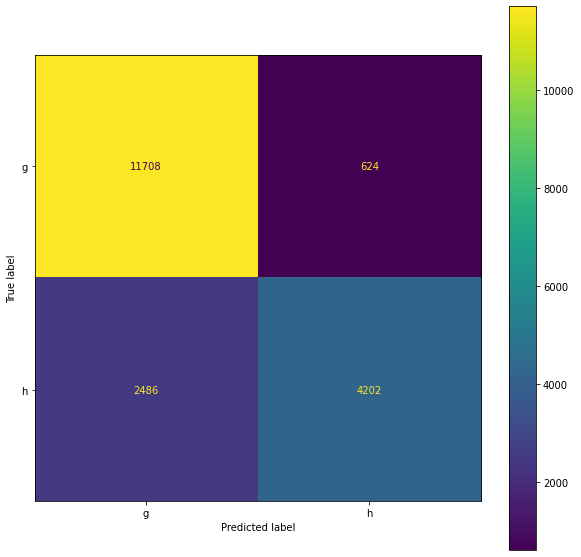

In [ ]:
best_n = df_condensed_confu_50.sort_values(by=['n'], ascending=False)['n'].iloc[0]

fig, ax = plt.subplots(figsize=(10,10))
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, condensed_y_pred_50[best_n]),display_labels=knn.classes_)
disp.plot(ax=ax, values_format='')
plt.savefig('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_best_n_condensed_50_plot.png')

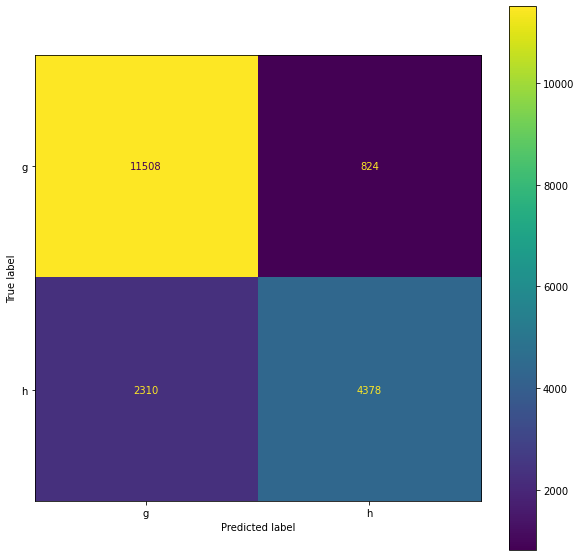

In [ ]:
best_n = df_condensed_confu_75.sort_values(by=['n'], ascending=False)['n'].iloc[0]

fig, ax = plt.subplots(figsize=(10,10))
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, condensed_y_pred_75[best_n]),display_labels=knn.classes_)
disp.plot(ax=ax, values_format='')
plt.savefig('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_best_n_condensed_75_plot.png')

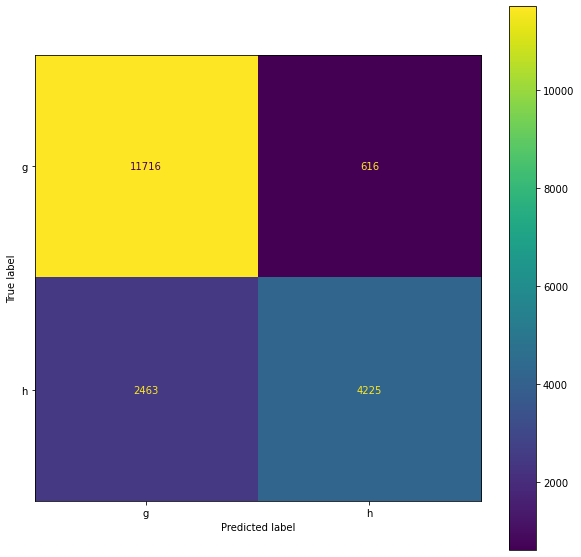

In [ ]:
best_n = df_confu.sort_values(by=['n'], ascending=False)['n'].iloc[0]

fig, ax = plt.subplots(figsize=(10,10))
disp = metrics.ConfusionMatrixDisplay(metrics.confusion_matrix(y_true, y_pred[best_n]),display_labels=knn.classes_)
disp.plot(ax=ax, values_format='')
plt.savefig('drive/MyDrive/Dataset/result/'+uses_dataset+'/'+uses_dataset+'_best_n_uncondensed_plot.png')